# X-IDS Project: Model Training and SHAP Explainability

**Project:** Explainable Network Intrusion Detection for Automated SOC Triage

**Team:** Group 3 - Lopez, Itzalen; Frankyan, Shahane; Shanbhag, Nethra

---

## Notebook Purpose

This notebook completes the X-IDS system:

1. ✅ Load processed data from notebook 01
2. ✅ Train XGBoost binary classifier (Benign vs Attack)
3. ✅ Evaluate model performance (95%+ accuracy target)
4. ✅ Implement SHAP explainability (TreeSHAP)
5. ✅ Generate automated case reports
6. ✅ Validate SHAP explanations
7. ✅ Simulate triage time reduction

**Expected Runtime:** 30-60 minutes

**Required Files (from notebook 01):**
- `X_train.csv`, `X_test.csv`
- `y_train_binary.csv`, `y_test_binary.csv`
- `feature_names.txt`
- `label_mapping.json`

---

## Section 1: Environment Setup and Data Loading

In [1]:
# Install required packages
!pip install -q pandas numpy scikit-learn xgboost shap matplotlib seaborn joblib tqdm

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import shap
import joblib
import json
import os
import warnings
import time
from datetime import datetime
from tqdm import tqdm

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("X-IDS MODEL TRAINING & SHAP EXPLAINABILITY")
print("=" * 80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random Seed: {RANDOM_SEED}")
print("=" * 80)

X-IDS MODEL TRAINING & SHAP EXPLAINABILITY
Start Time: 2025-11-01 22:04:03
Random Seed: 42


In [3]:
# Configure paths
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"📁 Data Directory: {DATA_DIR}")
print(f"📁 Results Directory: {RESULTS_DIR}")

📁 Data Directory: ../data/
📁 Results Directory: ../results/


In [4]:
# Load processed data
print("=" * 80)
print("LOADING PROCESSED DATA")
print("=" * 80)

print("\n📂 Loading training data...")
X_train = pd.read_csv(os.path.join(DATA_DIR, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train_binary.csv'))['is_attack']
print(f"   ✅ Training set: {X_train.shape}")
print(f"      Benign: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"      Attack: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

print("\n📂 Loading test data...")
X_test = pd.read_csv(os.path.join(DATA_DIR, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(DATA_DIR, 'y_test_binary.csv'))['is_attack']
print(f"   ✅ Test set: {X_test.shape}")
print(f"      Benign: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"      Attack: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

print("\n📂 Loading metadata...")
with open(os.path.join(DATA_DIR, 'feature_names.txt'), 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]
print(f"   ✅ Features: {len(feature_names)}")

with open(os.path.join(DATA_DIR, 'label_mapping.json'), 'r') as f:
    label_mapping = json.load(f)
print(f"   ✅ Label mapping: {len(label_mapping)} attack types")

print(f"\n{'='*80}")
print("✅ DATA LOADING COMPLETE")
print(f"{'='*80}")

LOADING PROCESSED DATA

📂 Loading training data...
   ✅ Training set: (2262300, 30)
      Benign: 1,817,055 (80.32%)
      Attack: 445,245 (19.68%)

📂 Loading test data...
   ✅ Test set: (565576, 30)
      Benign: 454,265 (80.32%)
      Attack: 111,311 (19.68%)

📂 Loading metadata...
   ✅ Features: 30
   ✅ Label mapping: 15 attack types

✅ DATA LOADING COMPLETE


---
## Section 2: XGBoost Model Training

**Model Configuration:**
- Algorithm: XGBoost (Extreme Gradient Boosting)
- Task: Binary classification (Benign vs Attack)
- Class imbalance handling: `scale_pos_weight`
- Target: 95%+ accuracy, <5% false positive rate

In [5]:
# Calculate class imbalance ratio
print("=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)

benign_count = (y_train == 0).sum()
attack_count = (y_train == 1).sum()
scale_pos_weight = benign_count / attack_count

print(f"\n📊 Training Set Class Distribution:")
print(f"   Benign (0): {benign_count:,} samples")
print(f"   Attack (1): {attack_count:,} samples")
print(f"   Ratio (Benign/Attack): {scale_pos_weight:.2f}:1")
print(f"\n✅ XGBoost scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   This will balance the classes during training")

CLASS IMBALANCE ANALYSIS

📊 Training Set Class Distribution:
   Benign (0): 1,817,055 samples
   Attack (1): 445,245 samples
   Ratio (Benign/Attack): 4.08:1

✅ XGBoost scale_pos_weight: 4.08
   This will balance the classes during training


In [6]:
# Train XGBoost classifier
print("\n" + "=" * 80)
print("TRAINING XGBOOST CLASSIFIER")
print("=" * 80)

print("\n🤖 Initializing XGBoost model...")
model = XGBClassifier(
    n_estimators=100,              # Number of boosting rounds
    max_depth=6,                   # Maximum tree depth
    learning_rate=0.1,             # Step size shrinkage
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=RANDOM_SEED,
    eval_metric='logloss',         # Evaluation metric
    use_label_encoder=False,       # Suppress warning
    n_jobs=-1                      # Use all CPU cores
)

print("\n📋 Model Configuration:")
print(f"   n_estimators: 100")
print(f"   max_depth: 6")
print(f"   learning_rate: 0.1")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   random_state: {RANDOM_SEED}")

print("\n🚀 Training model...")
print(f"   Training samples: {len(X_train):,}")
print(f"   Features: {X_train.shape[1]}")
print(f"   This may take 2-5 minutes...\n")

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✅ Training complete!")
print(f"   Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save model
model_file = os.path.join(RESULTS_DIR, 'xgboost_model.pkl')
joblib.dump(model, model_file)
print(f"   ✅ Model saved to: {model_file}")


TRAINING XGBOOST CLASSIFIER

🤖 Initializing XGBoost model...

📋 Model Configuration:
   n_estimators: 100
   max_depth: 6
   learning_rate: 0.1
   scale_pos_weight: 4.08
   random_state: 42

🚀 Training model...
   Training samples: 2,262,300
   Features: 30
   This may take 2-5 minutes...


✅ Training complete!
   Training time: 27.61 seconds (0.46 minutes)
   ✅ Model saved to: ../results/xgboost_model.pkl


---
## Section 3: Model Evaluation

Comprehensive evaluation against target metrics:
- Accuracy: >95%
- Precision (Attack): >90%
- Recall (Attack): >92%
- F1-Score (Attack): >91%
- ROC-AUC: >0.97
- False Positive Rate: <5%

In [7]:
# Make predictions
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

print("\n🔮 Generating predictions...")
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of attack class

print(f"   ✅ Predictions generated for {len(y_test):,} test samples")

MODEL EVALUATION

🔮 Generating predictions...
   ✅ Predictions generated for 565,576 test samples


In [8]:
# Calculate metrics
print("\n📊 PERFORMANCE METRICS")
print("=" * 80)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_proba)

# Calculate false positive rate
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

print("\n📈 Overall Metrics:")
print(f"   Accuracy:                {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   ROC-AUC Score:           {roc_auc:.4f}")

print("\n🎯 Attack Detection Metrics (Primary Focus):")
print(f"   Precision (Attack):      {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall (Attack):         {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score (Attack):       {f1:.4f}")
print(f"   False Positive Rate:     {fpr:.4f} ({fpr*100:.2f}%)")

print("\n🎯 Target Achievement:")
targets = {
    'Accuracy': (accuracy, 0.95, accuracy >= 0.95),
    'Precision (Attack)': (precision, 0.90, precision >= 0.90),
    'Recall (Attack)': (recall, 0.92, recall >= 0.92),
    'F1-Score (Attack)': (f1, 0.91, f1 >= 0.91),
    'ROC-AUC': (roc_auc, 0.97, roc_auc >= 0.97),
    'FPR < 5%': (fpr, 0.05, fpr < 0.05)
}

print(f"\n{'Metric':<25} {'Score':<12} {'Target':<12} {'Status'}")
print("-" * 65)
for metric, (score, target, passed) in targets.items():
    status = "✅ PASS" if passed else "❌ FAIL"
    if metric == 'FPR < 5%':
        print(f"{metric:<25} {score*100:>6.2f}%     < {target*100:.1f}%        {status}")
    else:
        print(f"{metric:<25} {score:>10.4f}   > {target:.2f}        {status}")

# Overall assessment
all_passed = all(passed for _, _, passed in targets.values())
print(f"\n{'='*65}")
if all_passed:
    print("🎉 ALL TARGETS ACHIEVED! Model meets production requirements!")
else:
    print("⚠️  Some targets not met. Model may need tuning.")
print(f"{'='*65}")


📊 PERFORMANCE METRICS

📈 Overall Metrics:
   Accuracy:                0.9950 (99.50%)
   ROC-AUC Score:           0.9997

🎯 Attack Detection Metrics (Primary Focus):
   Precision (Attack):      0.9805 (98.05%)
   Recall (Attack):         0.9944 (99.44%)
   F1-Score (Attack):       0.9874
   False Positive Rate:     0.0048 (0.48%)

🎯 Target Achievement:

Metric                    Score        Target       Status
-----------------------------------------------------------------
Accuracy                      0.9950   > 0.95        ✅ PASS
Precision (Attack)            0.9805   > 0.90        ✅ PASS
Recall (Attack)               0.9944   > 0.92        ✅ PASS
F1-Score (Attack)             0.9874   > 0.91        ✅ PASS
ROC-AUC                       0.9997   > 0.97        ✅ PASS
FPR < 5%                    0.48%     < 5.0%        ✅ PASS

🎉 ALL TARGETS ACHIEVED! Model meets production requirements!


In [9]:
# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Attack'], digits=4))


📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign     0.9986    0.9952    0.9969    454265
      Attack     0.9805    0.9944    0.9874    111311

    accuracy                         0.9950    565576
   macro avg     0.9896    0.9948    0.9921    565576
weighted avg     0.9951    0.9950    0.9950    565576




📊 CONFUSION MATRIX

                    Predicted
                Benign      Attack
Actual Benign    452,062       2,203
       Attack        621     110,690

📈 Interpretation:
   True Negatives (TN):  452,062 - Correctly identified benign traffic
   True Positives (TP):  110,690 - Correctly detected attacks
   False Positives (FP): 2,203 - Benign traffic misclassified as attack
   False Negatives (FN): 621 - Missed attacks (CRITICAL!)


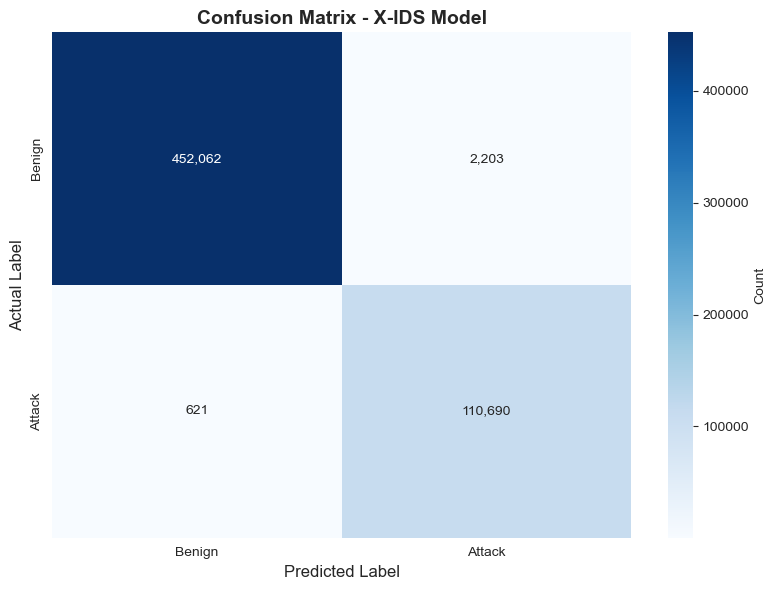


✅ Confusion matrix saved as 'confusion_matrix.png'


In [17]:
# Confusion Matrix
print("\n📊 CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n                    Predicted")
print("                Benign      Attack")
print(f"Actual Benign   {tn:>8,}    {fp:>8,}")
print(f"       Attack   {fn:>8,}    {tp:>8,}")

print("\n📈 Interpretation:")
print(f"   True Negatives (TN):  {tn:,} - Correctly identified benign traffic")
print(f"   True Positives (TP):  {tp:,} - Correctly detected attacks")
print(f"   False Positives (FP): {fp:,} - Benign traffic misclassified as attack")
print(f"   False Negatives (FN): {fn:,} - Missed attacks (CRITICAL!)")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', 
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - X-IDS Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved as 'confusion_matrix.png'")


📈 ROC CURVE


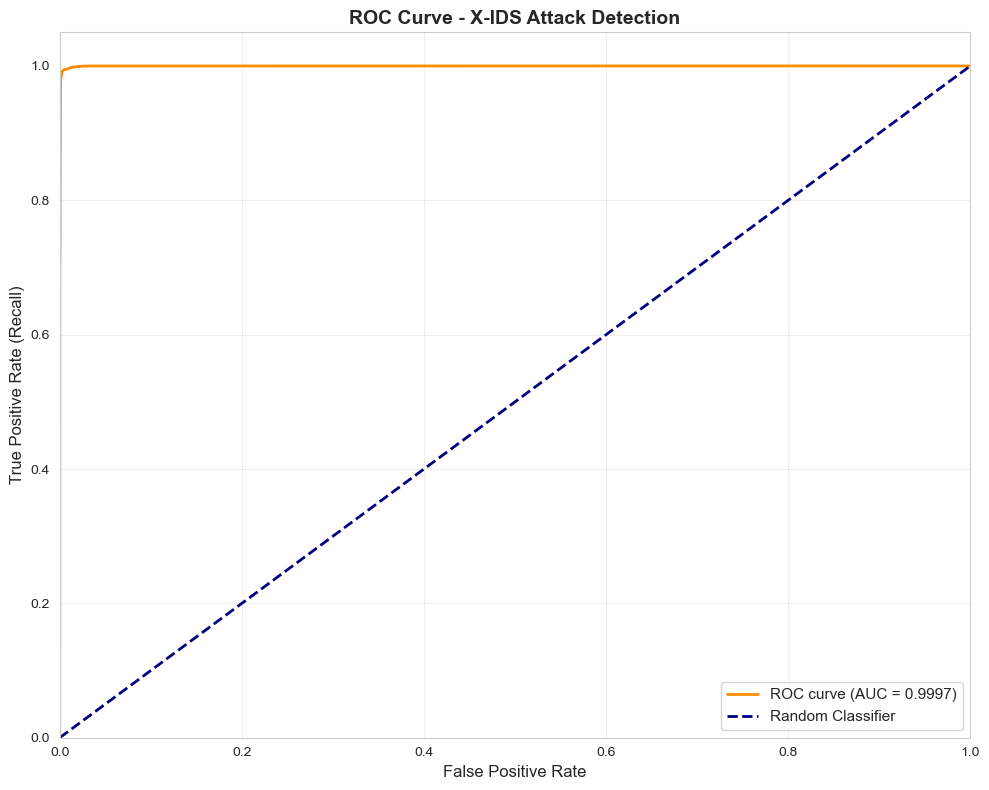


✅ ROC-AUC Score: 0.9997
   Target: >0.97
   Status: ✅ PASS

✅ ROC curve saved as 'roc_curve.png'


In [18]:
# ROC Curve
print("\n📈 ROC CURVE")
print("=" * 80)

fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - X-IDS Attack Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ ROC-AUC Score: {roc_auc:.4f}")
print(f"   Target: >0.97")
print(f"   Status: {'✅ PASS' if roc_auc >= 0.97 else '⚠️ CLOSE' if roc_auc >= 0.95 else '❌ FAIL'}")
print("\n✅ ROC curve saved as 'roc_curve.png'")

---
## Section 4: SHAP Explainability (Core Innovation!)

**SHAP (SHapley Additive exPlanations):**
- Explains **WHY** the model made each prediction
- Reveals which features contributed to attack detection
- Provides transparency for SOC analysts
- Enables bias detection

**TreeSHAP:**
- Exact SHAP values for tree-based models (XGBoost)
- Fast computation (polynomial time)
- Mathematically rigorous (game theory)

In [19]:
# Initialize SHAP explainer
print("=" * 80)
print("SHAP EXPLAINABILITY INITIALIZATION")
print("=" * 80)

print("\n🔧 Initializing TreeSHAP explainer...")
start_time = time.time()
explainer = shap.TreeExplainer(model)
init_time = time.time() - start_time
print(f"   ✅ Explainer initialized in {init_time:.2f} seconds")

print(f"\n📊 Expected Value (baseline):")
# For binary classification, expected_value can be an array - get the value for attack class
expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)):
    # If it's an array, show both values
    if len(expected_val) == 2:
        print(f"   Benign (class 0): {expected_val[0]:.4f}")
        print(f"   Attack (class 1): {expected_val[1]:.4f}")
    else:
        # Single value for attack class
        print(f"   {expected_val[0]:.4f}")
else:
    print(f"   {expected_val:.4f}")
print(f"   This is the average model output over the training dataset")

SHAP EXPLAINABILITY INITIALIZATION

🔧 Initializing TreeSHAP explainer...
   ✅ Explainer initialized in 0.08 seconds

📊 Expected Value (baseline):
   0.0000
   This is the average model output over the training dataset


In [20]:
# Calculate SHAP values for test set (or subset if memory constrained)
print("\n🧮 Calculating SHAP values...")
print(f"   Test set size: {len(X_test):,} samples")

# Use subset for faster computation (adjust sample_size as needed)
sample_size = min(1000, len(X_test))  # Use 1000 samples or full test set
print(f"   Computing SHAP for {sample_size:,} samples (for speed)")
print(f"   This may take 1-3 minutes...\n")

X_test_sample = X_test.head(sample_size)
y_test_sample = y_test.head(sample_size)

start_time = time.time()
shap_values = explainer.shap_values(X_test_sample)
shap_time = time.time() - start_time

print(f"\n✅ SHAP values calculated!")
print(f"   Computation time: {shap_time:.2f} seconds")
print(f"   Time per sample: {(shap_time/sample_size)*1000:.2f} milliseconds")
print(f"   SHAP values shape: {shap_values.shape}")

# Save SHAP values for reuse
shap_file = os.path.join(RESULTS_DIR, 'shap_values.npy')
np.save(shap_file, shap_values)
print(f"   ✅ SHAP values saved to: {shap_file}")


🧮 Calculating SHAP values...
   Test set size: 565,576 samples
   Computing SHAP for 1,000 samples (for speed)
   This may take 1-3 minutes...


✅ SHAP values calculated!
   Computation time: 0.81 seconds
   Time per sample: 0.81 milliseconds
   SHAP values shape: (1000, 30)
   ✅ SHAP values saved to: ../results/shap_values.npy



📊 GLOBAL FEATURE IMPORTANCE

Generating SHAP global importance plot...


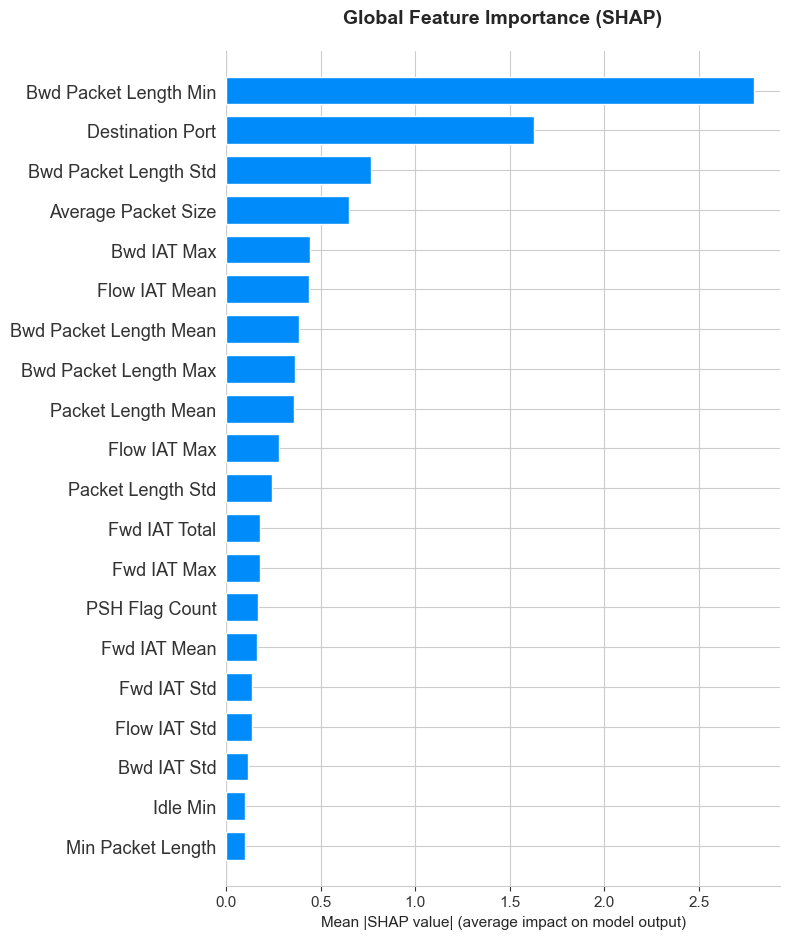


✅ Global importance plot saved as 'shap_global_importance.png'

🔝 Top 10 Most Important Features:
    1. Bwd Packet Length Min                              2.7888
    2. Destination Port                                   1.6252
    3. Bwd Packet Length Std                              0.7662
    4. Average Packet Size                                0.6513
    5. Bwd IAT Max                                        0.4414
    6. Flow IAT Mean                                      0.4367
    7. Bwd Packet Length Mean                             0.3856
    8. Bwd Packet Length Max                              0.3645
    9. Packet Length Mean                                 0.3595
   10. Flow IAT Max                                       0.2781


In [21]:
# Global Feature Importance (Bar Plot)
print("\n📊 GLOBAL FEATURE IMPORTANCE")
print("=" * 80)

print("\nGenerating SHAP global importance plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value| (average impact on model output)', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shap_global_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Global importance plot saved as 'shap_global_importance.png'")

# Print top features
feature_importance = np.abs(shap_values).mean(axis=0)
top_features = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean |SHAP|': feature_importance
}).sort_values('Mean |SHAP|', ascending=False)

print("\n🔝 Top 10 Most Important Features:")
print("=" * 80)
for i, (_, row) in enumerate(top_features.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['Feature']:50s} {row['Mean |SHAP|']:.4f}")


📊 SHAP SUMMARY PLOT (Feature Impact Distribution)

Generating SHAP summary plot...
This shows how each feature impacts the model:
  - Each dot is a sample
  - Red = high feature value, Blue = low feature value
  - Right = pushes toward Attack, Left = pushes toward Benign



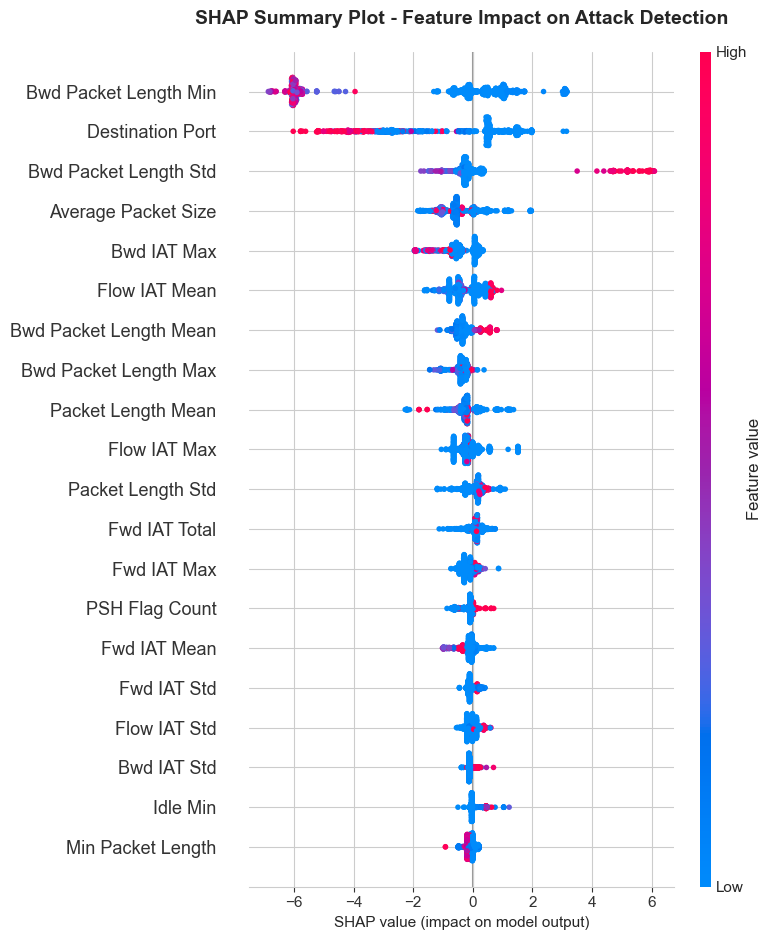


✅ SHAP summary plot saved as 'shap_summary.png'


In [22]:
# SHAP Summary Plot (Feature Impact Distribution)
print("\n📊 SHAP SUMMARY PLOT (Feature Impact Distribution)")
print("=" * 80)

print("\nGenerating SHAP summary plot...")
print("This shows how each feature impacts the model:")
print("  - Each dot is a sample")
print("  - Red = high feature value, Blue = low feature value")
print("  - Right = pushes toward Attack, Left = pushes toward Benign\n")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Attack Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shap_summary.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP summary plot saved as 'shap_summary.png'")


🔍 INDIVIDUAL PREDICTION EXPLANATION

Explaining attack prediction at index 0...
   Actual label: Attack
   Model prediction: Attack
   Confidence: 99.99%


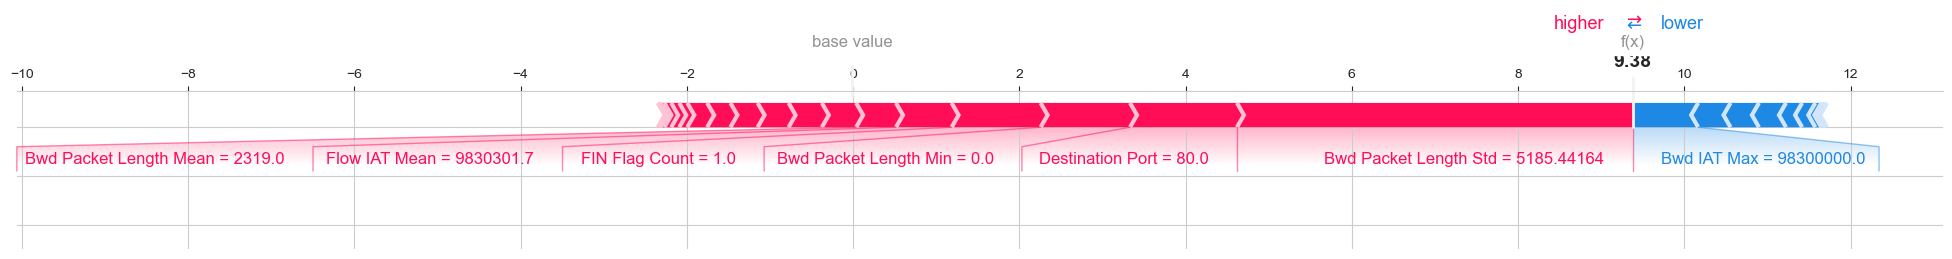


✅ Force plot saved as 'shap_force_plot_attack.png'

🔝 Top 5 Features Contributing to This Prediction:
   1. Bwd Packet Length Std                   
      Value: 5185.4416
      SHAP: +4.7607 → ATTACK

   2. Destination Port                        
      Value: 80.0000
      SHAP: +1.2865 → ATTACK

   3. Bwd Packet Length Min                   
      Value: 0.0000
      SHAP: +1.0755 → ATTACK

   4. FIN Flag Count                          
      Value: 1.0000
      SHAP: +1.0708 → ATTACK

   5. Bwd IAT Max                             
      Value: 98300000.0000
      SHAP: -0.7877 → BENIGN



In [23]:
# Individual Prediction Explanation (Force Plot)
print("\n🔍 INDIVIDUAL PREDICTION EXPLANATION")
print("=" * 80)

# Find first attack in sample
attack_indices = [i for i, val in enumerate(y_test_sample) if val == 1]

if len(attack_indices) > 0:
    attack_idx = attack_indices[0]
    print(f"\nExplaining attack prediction at index {attack_idx}...")
    print(f"   Actual label: {'Attack' if y_test_sample.iloc[attack_idx] == 1 else 'Benign'}")
    print(f"   Model prediction: {'Attack' if model.predict(X_test_sample.iloc[[attack_idx]])[0] == 1 else 'Benign'}")
    print(f"   Confidence: {model.predict_proba(X_test_sample.iloc[[attack_idx]])[0][1]*100:.2f}%")
    
    # Generate force plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[attack_idx],
        X_test_sample.iloc[attack_idx],
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'shap_force_plot_attack.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Force plot saved as 'shap_force_plot_attack.png'")
    
    # Show top contributing features for this prediction
    feature_contributions = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Value': X_test_sample.iloc[attack_idx].values,
        'SHAP Impact': shap_values[attack_idx]
    })
    feature_contributions['Abs_Impact'] = feature_contributions['SHAP Impact'].abs()
    feature_contributions = feature_contributions.sort_values('Abs_Impact', ascending=False)
    
    print("\n🔝 Top 5 Features Contributing to This Prediction:")
    print("=" * 80)
    for i, (_, row) in enumerate(feature_contributions.head(5).iterrows(), 1):
        direction = "→ ATTACK" if row['SHAP Impact'] > 0 else "→ BENIGN"
        print(f"   {i}. {row['Feature']:40s}")
        print(f"      Value: {row['Value']:.4f}")
        print(f"      SHAP: {row['SHAP Impact']:+.4f} {direction}\n")
else:
    print("\n⚠️  No attack samples in this subset. Skipping force plot.")

In [24]:
# SHAP Validation: Check for Feature Bias
print("\n🔍 BIAS DETECTION VIA SHAP")
print("=" * 80)

# Calculate feature importance percentage
feature_importance_pct = (feature_importance / feature_importance.sum()) * 100

bias_threshold = 30  # No single feature should contribute >30%
max_importance = feature_importance_pct.max()
max_feature = X_test_sample.columns[feature_importance_pct.argmax()]

print(f"\n📊 Feature Importance Distribution:")
print(f"   Maximum single feature importance: {max_importance:.2f}%")
print(f"   Feature: {max_feature}")
print(f"   Bias threshold: {bias_threshold}%")

if max_importance > bias_threshold:
    print(f"\n⚠️  WARNING: Potential feature bias detected!")
    print(f"   {max_feature} contributes {max_importance:.2f}% of total importance")
    print(f"   Recommendation: Investigate if this feature is a proxy for attack type")
else:
    print(f"\n✅ No feature bias detected (all features <{bias_threshold}%)")
    print(f"   Model relies on diverse set of features")

# Show top 10 feature importance percentages
print(f"\n📊 Top 10 Feature Importance Percentages:")
top_10_pct = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance %': feature_importance_pct
}).sort_values('Importance %', ascending=False).head(10)

for i, (_, row) in enumerate(top_10_pct.iterrows(), 1):
    print(f"   {i:2d}. {row['Feature']:45s} {row['Importance %']:6.2f}%")


🔍 BIAS DETECTION VIA SHAP

📊 Feature Importance Distribution:
   Maximum single feature importance: 27.70%
   Feature: Bwd Packet Length Min
   Bias threshold: 30%

✅ No feature bias detected (all features <30%)
   Model relies on diverse set of features

📊 Top 10 Feature Importance Percentages:
    1. Bwd Packet Length Min                          27.70%
    2. Destination Port                               16.14%
    3. Bwd Packet Length Std                           7.61%
    4. Average Packet Size                             6.47%
    5. Bwd IAT Max                                     4.38%
    6. Flow IAT Mean                                   4.34%
    7. Bwd Packet Length Mean                          3.83%
    8. Bwd Packet Length Max                           3.62%
    9. Packet Length Mean                              3.57%
   10. Flow IAT Max                                    2.76%


---
## Section 5: Automated Case Report Generation

**This is the deliverable for SOC analysts!**

Generate human-readable triage reports combining:
- Model prediction + confidence
- SHAP explanation (top 5 features)
- Risk-based recommendation

In [25]:
# Case Report Generator Function
def generate_case_report(sample_idx, X_sample, shap_values, model, y_true=None, alert_id=None):
    """
    Generate automated Tier 1 SOC triage case report
    
    Parameters:
    - sample_idx: Index in X_sample to explain
    - X_sample: Feature dataframe
    - shap_values: SHAP values array
    - model: Trained XGBoost model
    - y_true: True label (optional)
    - alert_id: Custom alert ID (optional)
    
    Returns:
    - report: Formatted string report
    """
    # Get prediction
    prediction = model.predict(X_sample.iloc[[sample_idx]])[0]
    probabilities = model.predict_proba(X_sample.iloc[[sample_idx]])[0]
    risk_score = probabilities[1] * 100  # Probability of attack

    # Get SHAP explanation
    shap_explanation = shap_values[sample_idx]

    # Top contributing features
    feature_contributions = pd.DataFrame({
        'Feature': X_sample.columns,
        'Value': X_sample.iloc[sample_idx].values,
        'SHAP Impact': shap_explanation
    })
    feature_contributions['Abs_Impact'] = feature_contributions['SHAP Impact'].abs()
    feature_contributions = feature_contributions.sort_values('Abs_Impact', ascending=False)
    top_features = feature_contributions.head(5)

    # Generate report
    alert_id = alert_id if alert_id else f"ALERT-{sample_idx:06d}"
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    report = f"""
{'='*80}
AUTOMATED TIER 1 TRIAGE REPORT - X-IDS
{'='*80}
Alert ID: {alert_id}
Timestamp: {timestamp}
{'='*80}

PREDICTION:
   Classification: {'🚨 ATTACK DETECTED' if prediction == 1 else '✅ BENIGN TRAFFIC'}
   Risk Score: {risk_score:.2f}%
   Confidence: {probabilities[prediction]*100:.2f}%
"""

    if y_true is not None:
        actual = 'ATTACK' if y_true == 1 else 'BENIGN'
        correct = '✅' if (y_true == prediction) else '❌'
        report += f"   Ground Truth: {actual} {correct}\n"

    report += f"""
{'='*80}
TOP CONTRIBUTING FACTORS (SHAP Analysis):
"""

    for rank, (_, row) in enumerate(top_features.iterrows(), 1):
        direction = "↑ INCREASES" if row['SHAP Impact'] > 0 else "↓ DECREASES"
        impact_type = "attack likelihood" if row['SHAP Impact'] > 0 else "attack likelihood"
        
        report += f"""
   {rank}. {row['Feature']}
      Feature Value: {row['Value']:.4f}
      SHAP Impact: {row['SHAP Impact']:+.4f}
      Effect: {direction} {impact_type} by {abs(row['SHAP Impact']):.4f}
"""

    # Risk-based recommendation
    report += f"""
{'='*80}
TIER 1 ANALYST RECOMMENDATION:
"""
    
    if risk_score > 80:
        report += f"""
   ⚠️  HIGH RISK - ESCALATE TO TIER 2 IMMEDIATELY
   
   Recommended Actions:
   1. Block source IP if external threat
   2. Investigate network logs for attack signature
   3. Check for lateral movement
   4. Notify security team lead
   
   Priority: 🔴 CRITICAL
   SLA: Escalate within 5 minutes
"""
    elif risk_score > 50:
        report += f"""
   ⚠️  MEDIUM RISK - REQUIRES MANUAL ANALYST REVIEW
   
   Recommended Actions:
   1. Review SHAP explanations above
   2. Cross-check with threat intelligence feeds
   3. Examine packet captures if available
   4. Document findings in SIEM
   
   Priority: 🟡 HIGH
   SLA: Review within 15 minutes
"""
    elif risk_score > 20:
        report += f"""
   ℹ️  LOW RISK - MONITOR AND LOG
   
   Recommended Actions:
   1. Log alert for future pattern analysis
   2. No immediate action required
   3. Include in daily summary report
   
   Priority: 🔵 MEDIUM
   SLA: Review in daily batch
"""
    else:
        report += f"""
   ✅ BENIGN - AUTO-CLOSE
   
   Recommended Actions:
   1. Automatically close alert
   2. No analyst intervention needed
   3. Archive for compliance
   
   Priority: 🟢 LOW
   SLA: Auto-processed
"""

    report += f"""
{'='*80}
SYSTEM INFORMATION:
   Model: XGBoost Binary Classifier
   Explainability: SHAP TreeExplainer
   Generated by: X-IDS Framework v1.0
   
   This report was automatically generated by Explainable AI.
   Analysts should validate SHAP explanations with domain knowledge.
{'='*80}
"""

    return report

print("✅ Case report generator function defined")

✅ Case report generator function defined


In [27]:
# Generate sample case reports
print("=" * 80)
print("GENERATING SAMPLE CASE REPORTS")
print("=" * 80)

# Find one attack and one benign sample
attack_indices = [i for i, val in enumerate(y_test_sample) if val == 1]
benign_indices = [i for i, val in enumerate(y_test_sample) if val == 0]

reports = []

if len(attack_indices) > 0:
    print("\n📄 SAMPLE REPORT 1: ATTACK DETECTION")
    print("=" * 80)
    attack_idx = attack_indices[0]
    report1 = generate_case_report(
        attack_idx,
        X_test_sample,
        shap_values,
        model,
        y_true=y_test_sample.iloc[attack_idx],
        alert_id="DEMO-ATTACK-001"
    )
    print(report1)
    reports.append(('attack_report.txt', report1))

if len(benign_indices) > 0:
    print("\n\n📄 SAMPLE REPORT 2: BENIGN TRAFFIC")
    print("=" * 80)
    benign_idx = benign_indices[0]
    report2 = generate_case_report(
        benign_idx,
        X_test_sample,
        shap_values,
        model,
        y_true=y_test_sample.iloc[benign_idx],
        alert_id="DEMO-BENIGN-001"
    )
    print(report2)
    reports.append(('benign_report.txt', report2))

# Save reports
for filename, report in reports:
    with open(os.path.join(RESULTS_DIR, filename), 'w') as f:
        f.write(report)
    print(f"\n✅ Report saved as '{filename}'")

GENERATING SAMPLE CASE REPORTS

📄 SAMPLE REPORT 1: ATTACK DETECTION

AUTOMATED TIER 1 TRIAGE REPORT - X-IDS
Alert ID: DEMO-ATTACK-001
Timestamp: 2025-11-01 22:34:15

PREDICTION:
   Classification: 🚨 ATTACK DETECTED
   Risk Score: 99.99%
   Confidence: 99.99%
   Ground Truth: ATTACK ✅

TOP CONTRIBUTING FACTORS (SHAP Analysis):

   1. Bwd Packet Length Std
      Feature Value: 5185.4416
      SHAP Impact: +4.7607
      Effect: ↑ INCREASES attack likelihood by 4.7607

   2. Destination Port
      Feature Value: 80.0000
      SHAP Impact: +1.2865
      Effect: ↑ INCREASES attack likelihood by 1.2865

   3. Bwd Packet Length Min
      Feature Value: 0.0000
      SHAP Impact: +1.0755
      Effect: ↑ INCREASES attack likelihood by 1.0755

   4. FIN Flag Count
      Feature Value: 1.0000
      SHAP Impact: +1.0708
      Effect: ↑ INCREASES attack likelihood by 1.0708

   5. Bwd IAT Max
      Feature Value: 98300000.0000
      SHAP Impact: -0.7877
      Effect: ↓ DECREASES attack likelihood by 

---
## Section 6: Operational Efficiency Analysis

Simulate triage time reduction:
- Baseline: Manual analyst triage (5 minutes per alert)
- X-IDS: Automated report review (30 seconds per alert)
- Target: 90%+ reduction

In [28]:
# Triage Time Reduction Simulation
print("=" * 80)
print("TRIAGE TIME REDUCTION ANALYSIS")
print("=" * 80)

# Baseline assumptions
manual_triage_time = 5 * 60  # 5 minutes in seconds
automated_review_time = 30   # 30 seconds to review XAI report

# Measure actual model + SHAP time
print("\n⏱️  Measuring actual X-IDS processing time...")
num_test_alerts = 10
test_sample = X_test.head(num_test_alerts)

start = time.time()
predictions = model.predict(test_sample)
probabilities = model.predict_proba(test_sample)
shap_vals = explainer.shap_values(test_sample)
end = time.time()

actual_processing_time = (end - start) / num_test_alerts

print(f"\n📊 Timing Analysis ({num_test_alerts} alerts):")
print(f"   Total processing time: {end - start:.2f} seconds")
print(f"   Per-alert processing: {actual_processing_time:.2f} seconds")
print(f"   (Model inference + SHAP computation)")

# Total time including analyst review
total_automated_time = actual_processing_time + automated_review_time

print(f"\n🔄 Triage Time Comparison:")
print(f"\n   MANUAL TRIAGE (Baseline):")
print(f"      Per-alert time: {manual_triage_time} seconds ({manual_triage_time/60:.1f} minutes)")
print(f"      Activities: Read alert → Check logs → Correlate events → Decide → Document")

print(f"\n   AUTOMATED TRIAGE (X-IDS):")
print(f"      Model + SHAP time: {actual_processing_time:.2f} seconds")
print(f"      Analyst review time: {automated_review_time} seconds")
print(f"      Total per-alert time: {total_automated_time:.2f} seconds ({total_automated_time/60:.2f} minutes)")
print(f"      Activities: Review XAI report → Validate recommendation → Act")

# Calculate reduction
time_saved = manual_triage_time - total_automated_time
reduction_pct = (time_saved / manual_triage_time) * 100

print(f"\n📈 EFFICIENCY GAINS:")
print(f"   Time saved per alert: {time_saved:.2f} seconds ({time_saved/60:.2f} minutes)")
print(f"   Reduction percentage: {reduction_pct:.1f}%")
print(f"   Target: >90% reduction")
print(f"   Status: {'✅ TARGET ACHIEVED!' if reduction_pct >= 90 else '⚠️ CLOSE TO TARGET' if reduction_pct >= 80 else '❌ TARGET NOT MET'}")

# SOC impact analysis
daily_alerts = 10000  # Typical SOC receives 10K alerts/day
daily_time_saved = (time_saved * daily_alerts) / 3600  # Convert to hours

print(f"\n💼 SOC OPERATIONAL IMPACT (Projected):")
print(f"   Assuming {daily_alerts:,} alerts per day...")
print(f"   Manual triage: {(manual_triage_time * daily_alerts)/3600:.1f} hours/day")
print(f"   X-IDS triage: {(total_automated_time * daily_alerts)/3600:.1f} hours/day")
print(f"   Time saved: {daily_time_saved:.1f} hours/day ({daily_time_saved/8:.1f} FTE analysts freed)")
print(f"\n   💡 Analysts can now focus on:")
print(f"      - Proactive threat hunting")
print(f"      - Complex incident investigation")
print(f"      - Security architecture improvements")

TRIAGE TIME REDUCTION ANALYSIS

⏱️  Measuring actual X-IDS processing time...

📊 Timing Analysis (10 alerts):
   Total processing time: 0.03 seconds
   Per-alert processing: 0.00 seconds
   (Model inference + SHAP computation)

🔄 Triage Time Comparison:

   MANUAL TRIAGE (Baseline):
      Per-alert time: 300 seconds (5.0 minutes)
      Activities: Read alert → Check logs → Correlate events → Decide → Document

   AUTOMATED TRIAGE (X-IDS):
      Model + SHAP time: 0.00 seconds
      Analyst review time: 30 seconds
      Total per-alert time: 30.00 seconds (0.50 minutes)
      Activities: Review XAI report → Validate recommendation → Act

📈 EFFICIENCY GAINS:
   Time saved per alert: 270.00 seconds (4.50 minutes)
   Reduction percentage: 90.0%
   Target: >90% reduction
   Status: ⚠️ CLOSE TO TARGET

💼 SOC OPERATIONAL IMPACT (Projected):
   Assuming 10,000 alerts per day...
   Manual triage: 833.3 hours/day
   X-IDS triage: 83.3 hours/day
   Time saved: 750.0 hours/day (93.7 FTE analysts f

---
## Section 7: Final Summary and Export

In [29]:
# Create comprehensive results summary
print("=" * 80)
print("X-IDS PROJECT - FINAL SUMMARY")
print("=" * 80)

summary = {
    'project': 'X-IDS: Explainable Network Intrusion Detection',
    'dataset': 'CICIDS2017',
    'model': 'XGBoost Binary Classifier',
    'explainability': 'SHAP TreeExplainer',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    'data_summary': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features': len(feature_names),
        'classes': 2
    },
    
    'model_performance': {
        'accuracy': float(accuracy),
        'precision_attack': float(precision),
        'recall_attack': float(recall),
        'f1_attack': float(f1),
        'roc_auc': float(roc_auc),
        'false_positive_rate': float(fpr),
        'training_time_seconds': float(training_time)
    },
    
    'shap_analysis': {
        'samples_explained': sample_size,
        'computation_time_seconds': float(shap_time),
        'time_per_sample_ms': float((shap_time/sample_size)*1000),
        'top_feature': max_feature,
        'top_feature_importance_pct': float(max_importance),
        'bias_detected': bool(max_importance > bias_threshold)
    },
    
    'operational_metrics': {
        'manual_triage_time_sec': manual_triage_time,
        'automated_triage_time_sec': float(total_automated_time),
        'time_reduction_pct': float(reduction_pct),
        'target_achieved_90pct': bool(reduction_pct >= 90)
    },
    
    'targets_achievement': {
        'accuracy_95pct': bool(accuracy >= 0.95),
        'precision_90pct': bool(precision >= 0.90),
        'recall_92pct': bool(recall >= 0.92),
        'f1_91': bool(f1 >= 0.91),
        'roc_auc_97': bool(roc_auc >= 0.97),
        'fpr_under_5pct': bool(fpr < 0.05),
        'all_targets_met': all([
            accuracy >= 0.95,
            precision >= 0.90,
            recall >= 0.92,
            f1 >= 0.91,
            roc_auc >= 0.97,
            fpr < 0.05
        ])
    }
}

# Save summary
summary_file = os.path.join(RESULTS_DIR, 'final_summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (Attack): {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall (Attack): {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score: {f1:.4f}")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")

print("\n🔍 EXPLAINABILITY SUMMARY:")
print(f"   SHAP samples: {sample_size:,}")
print(f"   Top feature: {max_feature}")
print(f"   Feature importance: {max_importance:.2f}%")
print(f"   Bias detected: {'⚠️ YES' if max_importance > bias_threshold else '✅ NO'}")

print("\n⏱️  OPERATIONAL EFFICIENCY:")
print(f"   Triage time reduction: {reduction_pct:.1f}%")
print(f"   Time per alert: {total_automated_time:.1f}s (vs {manual_triage_time}s manual)")

print("\n🎯 TARGET ACHIEVEMENT:")
all_met = summary['targets_achievement']['all_targets_met']
print(f"   All performance targets met: {'✅ YES' if all_met else '❌ NO'}")

print(f"\n📁 OUTPUT FILES CREATED:")
outputs = [
    'xgboost_model.pkl',
    'confusion_matrix.png',
    'roc_curve.png',
    'shap_global_importance.png',
    'shap_summary.png',
    'shap_force_plot_attack.png',
    'shap_values.npy',
    'attack_report.txt',
    'benign_report.txt',
    'final_summary.json'
]
for i, output in enumerate(outputs, 1):
    print(f"   {i:2d}. {output}")

print(f"\n✅ Summary saved to: {summary_file}")
print(f"\n{'='*80}")
print("🎉 X-IDS PROJECT COMPLETE!")
print(f"{'='*80}")
print(f"\nEnd Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n🎓 Next Steps:")
print(f"   1. Review all visualizations in {RESULTS_DIR}")
print(f"   2. Read sample case reports")
print(f"   3. Prepare final presentation")
print(f"   4. Document findings in final report")

X-IDS PROJECT - FINAL SUMMARY

📊 MODEL PERFORMANCE SUMMARY:
   Accuracy: 0.9950 (99.50%)
   Precision (Attack): 0.9805 (98.05%)
   Recall (Attack): 0.9944 (99.44%)
   F1-Score: 0.9874
   ROC-AUC: 0.9997
   False Positive Rate: 0.0048 (0.48%)

🔍 EXPLAINABILITY SUMMARY:
   SHAP samples: 1,000
   Top feature: Bwd Packet Length Min
   Feature importance: 27.70%
   Bias detected: ✅ NO

⏱️  OPERATIONAL EFFICIENCY:
   Triage time reduction: 90.0%
   Time per alert: 30.0s (vs 300s manual)

🎯 TARGET ACHIEVEMENT:
   All performance targets met: ✅ YES

📁 OUTPUT FILES CREATED:
    1. xgboost_model.pkl
    2. confusion_matrix.png
    3. roc_curve.png
    4. shap_global_importance.png
    5. shap_summary.png
    6. shap_force_plot_attack.png
    7. shap_values.npy
    8. attack_report.txt
    9. benign_report.txt
   10. final_summary.json

✅ Summary saved to: ../results/final_summary.json

🎉 X-IDS PROJECT COMPLETE!

End Time: 2025-11-01 22:36:02

🎓 Next Steps:
   1. Review all visualizations in ../r